In [49]:
# import packages
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from networkx import edge_betweenness_centrality as betweenness
from networkx.algorithms.community.centrality import girvan_newman
from networkx.algorithms.community import kernighan_lin_bisection
from networkx.algorithms import community
import networkx.algorithms.community as nx_comm
#from networkx.algorithms.community import louvain_communities
import itertools

In [2]:
alliance_net=pd.read_csv('alliance_v4.1_by_dyad_yearly.csv')
enemy_net=pd.read_csv('dyadic_mid_4.02.csv')
countryCodes=pd.read_csv('COW country codes.csv')

In [3]:
countryCodes.head()

,StateAbb,CCode,StateNme
0,USA,2,United States of America
1,CAN,20,Canada
2,BHM,31,Bahamas
3,CUB,40,Cuba
4,CUB,40,Cuba


In [4]:
countryCodesDict={}
for i in range(len(countryCodes)):
  key=countryCodes['StateAbb'][i]
  val=countryCodes['StateNme'][i]
  countryCodesDict[key]=val
countryCodesDict['USR']='Russia'
countryCodesDict['UGD']='Uganda'

In [65]:
def getAllianceDataByYear(year):
    alliance_net_year= alliance_net[alliance_net['year']==year]
    return alliance_net_year.reset_index().drop(columns='index')

def getEnemyDataByYear(year):
    enemy_net_year= enemy_net[enemy_net['year']==year]
    return enemy_net_year.reset_index().drop(columns='index')

def getAllianceGraph(alliance_data_year):
  # get edges
  edgeList=[]
  edgeStrength={}
  for i in range(len(alliance_data_year)):
    u=alliance_data_year['state_name1'][i]
    v=alliance_data_year['state_name2'][i]
    w1,w2,w3,w4=4,3,2,1
    edgeStrength[(u,v)]=w1*float(alliance_data_year['defense'][i])+w2*float(alliance_data_year['neutrality'][i])+w3*float(alliance_data_year['nonaggression'][i])+w4*float(alliance_data_year['entente'][i])
    edgeList.append((u,v,edgeStrength[(u,v)]))

  #print(edgeList)
  #create graph
  G=nx.Graph()
  G.add_weighted_edges_from(edgeList)
  return G,edgeStrength

def getSignedGraph(year):
  ady=getAllianceDataByYear(year)
  G,posEdgeStrength=getAllianceGraph(ady)
  enemy_data_year=getEnemyDataByYear(year)
  #print('pos',posEdgeStrength)
  hostilityLevel={
      0:1, #No militarized action (1)
      1:2, #Threat to use force (2)
      2:2, #Threat to blockade (2)
      3:2, #Threat to occupy terr. (2)
      4:2, #Threat to declare war (2)
      5:2, #Threat to use CBR weapons(2)
      6:2, #Threat to join war (2)
      7:3, #Show of force (3)
      8:3, #Alert (3)
      9:3, #Nuclear alert (3)
      10:3, #Mobilization (3)
      11:3, #Fortify border (3)
      12:4, #Border violation (4)
      13:4, #Blockade (4)
      14:4, #Occupation of territory (4)
      15:4, #Seizure (4)
      16:4, #Attack (4)
      17:4, #Clash (4)
      18:4, #Declaration of war (4)
      19:4, #Use of CBR weapons (4)
      20:5, #Begin interstate war (5)
      21:5 #Join interstate war (5)
  }
  negEdgeStrength={}
  edgeList=[]
  for i in range(len(enemy_data_year)):
    uu=enemy_data_year['namea'][i]
    vv=enemy_data_year['nameb'][i]
    u=countryCodesDict[uu]
    v=countryCodesDict[vv]
    negEdgeStrength[(u,v)]=-1*hostilityLevel[enemy_data_year['mid5hiact'][i]]
    edgeList.append((u,v,-1*hostilityLevel[enemy_data_year['mid5hiact'][i]]))
  #print('neg',negEdgeStrength)
  G.add_weighted_edges_from(edgeList)
  posEdgeStrength.update(negEdgeStrength)
  #print('comb',edgeStrength)
  return G,posEdgeStrength


def visualizeGraph(G,edgeLabel,layout='circular'):
  if layout=='planar':
    nx.draw_planar(G,with_labels=True)
    pos=nx.planar_layout(G)
    if edgeLabel!='':
      nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeLabel)

  elif layout=='kk':
    nx.draw_kamada_kawai(G,with_labels=True)
    pos=nx.kamada_kawai_layout(G)
    if edgeLabel!='':
      nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeLabel)
  else:
    nx.draw_circular(G,with_labels=True)
    pos=nx.circular_layout(G)
    if edgeLabel!='':
      nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeLabel)
  plt.show()

def visualizeSigns(G,edgeStrength):
  nx.draw_kamada_kawai(G,with_labels=True)
  edgeLabel={}
  for key,val in edgeStrength.items():
    if val>=0:
      edgeLabel[key]='+'
    else :
      edgeLabel[key]='-'
  pos=nx.kamada_kawai_layout(G)
  nx.draw_networkx_edge_labels(G,pos,edge_labels=edgeLabel)
  plt.show()

In [34]:
def find_country_rank(G,centrality_measure):
  if centrality_measure=='pagerank':
    try:
      cnt_rank_dict=nx.pagerank(G,max_iter=10000,tol=1e-7)
      countries_sorted=sorted(cnt_rank_dict, key=cnt_rank_dict.get,reverse=True)
      return countries_sorted
    except:
      return []
  elif centrality_measure=='eigen':
    try:
      cnt_rank_dict=nx.eigenvector_centrality(G,max_iter=10000,tol=1e-7,weight='weight')
      countries_sorted=sorted(cnt_rank_dict, key=cnt_rank_dict.get,reverse=True)
      return countries_sorted
    except:
      return []

  elif centrality_measure=='info':
    try:
      cnt_rank_dict=nx.information_centrality(G,max_iter=10000,tol=1e-1)
      countries_sorted=sorted(cnt_rank_dict, key=cnt_rank_dict.get,reverse=True)
      return countries_sorted
    except:
      return []

  #more to be added    

def getWorldLeaderPlot(cnt_meas):
  years=[]
  leader=[]
  for y in range(1901,2013):
    data=getAllianceDataByYear(y)
    G,es=getAllianceGraph(data)
    #print(len(G.nodes()))
    #continue
    lst=find_country_rank(G,cnt_meas)
    years.append(y)
    if len(lst)>0:
      leader.append(lst[0])
      print(years[-1],lst[0:3])
    else: leader.append('')
  return leader


def getUnbalancedTris(G,type=''): # number or percentage (default)
  unstable_triangles=0
  total_triangles=0
  if len(G.nodes())>2: triangles_lt=[list(x) for x in itertools.combinations(G.nodes(),3)]  
  triangles_list=[]
  for tri in triangles_lt:
    u,v,w=tri[0],tri[1],tri[2]
    if G.has_edge(u,v) and G.has_edge(w,v) and G.has_edge(u,w):
      total_triangles+=1
      s1='+' if G[u][v]['weight']>=0 else '-' 
      s2='+' if G[w][v]['weight']>=0 else '-' 
      s3='+' if G[u][w]['weight']>=0 else '-' 
      signlist=[s1,s2,s3] 
      pos=signlist.count('+')
      if(pos==2 or pos==0):
        unstable_triangles+=1
        triangles_list.append([u,v,w])
  print(triangles_list)
  if type=='num':
    if total_triangles!=0: return unstable_triangles
    else: return 0
  if total_triangles!=0: return unstable_triangles/total_triangles
  else: return 0 
  

In [7]:
worldLeaders=getWorldLeaderPlot('pagerank')

1901 ['United Kingdom', 'Portugal', 'Germany']
1902 ['United Kingdom', 'Italy', 'Germany']
1903 ['United Kingdom', 'Italy', 'Germany']
1904 ['United Kingdom', 'Austria-Hungary', 'Germany']
1905 ['United Kingdom', 'Germany', 'Austria-Hungary']
1906 ['United Kingdom', 'Austria-Hungary', 'Germany']
1907 ['United Kingdom', 'Austria-Hungary', 'Honduras']
1908 ['United Kingdom', 'Austria-Hungary', 'Honduras']
1909 ['United Kingdom', 'Honduras', 'Italy']
1910 ['United Kingdom', 'Honduras', 'Japan']
1911 ['United Kingdom', 'Honduras', 'Italy']
1912 ['United Kingdom', 'Bulgaria', 'Honduras']
1913 ['United Kingdom', 'Honduras', 'Italy']
1914 ['United Kingdom', 'Germany', 'Honduras']
1915 ['United Kingdom', 'Italy', 'Honduras']
1916 ['United Kingdom', 'Honduras', 'Romania']
1917 ['United Kingdom', 'Honduras', 'Bulgaria']
1918 ['United Kingdom', 'Honduras', 'Bulgaria']
1919 ['United Kingdom', 'Ecuador', 'Bolivia']
1920 ['United Kingdom', 'Ecuador', 'Bolivia']
1921 ['France', 'Romania', 'Czechoslov

In [9]:
worldLeadersDict={}
for c in worldLeaders:
  if c in worldLeadersDict:
    worldLeadersDict[c]+=1
  else:
    worldLeadersDict[c]=1
worldLeadersDict

{'': 11,
 'France': 5,
 'Russia': 24,
 'United Kingdom': 20,
 'United States of America': 52}

In [35]:
worldLeaders2=getWorldLeaderPlot('info')
#worldLeaders2

In [17]:
from networkx.algorithms.cluster import average_clustering
def most_central_edge(G):
    centrality = betweenness(G, weight="weight")
    return max(centrality, key=centrality.get)

def find_communities(G):
  comp=girvan_newman(G, most_valuable_edge=most_central_edge)
  return tuple(sorted(c) for c in next(comp))

def getAverageCCPlot():#clustering coefficient
  years=[]
  cc=[]
  for y in range(1901,2013):
    years.append(y)
    data=getAllianceDataByYear(y)
    G,es=getAllianceGraph(data)
    acc=average_clustering(G)
    cc.append(acc)

  plt.plot(years,cc)
  plt.xlabel('Years')
  plt.ylabel('Average Clustering Coefficient')
  plt.show()



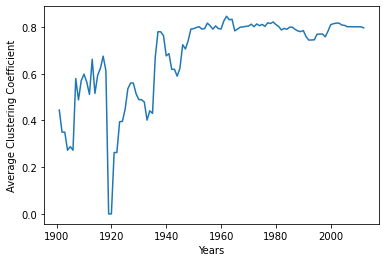

In [11]:
getAverageCCPlot()

In [37]:
#G1 (WW1)
alliance_data_1913=getAllianceDataByYear(1913)
alliance_data_1913.head()

,version4id,ccode1,state_name1,ccode2,state_name2,dyad_st_day,dyad_st_month,dyad_st_year,dyad_end_day,dyad_end_month,dyad_end_year,left_censor,right_censor,defense,neutrality,nonaggression,entente,year,version
0,1,200,United Kingdom,235,Portugal,1,1,1816,NaN,NaN,2012,1,1,1,0,1.0,0.0,1913,4.1
1,64,255,Germany,300,Austria-Hungary,7,10,1879,3.0,11.0,1918,0,0,1,1,0.0,0.0,1913,4.1
2,67,255,Germany,300,Austria-Hungary,20,5,1882,3.0,11.0,1918,0,0,1,0,0.0,0.0,1913,4.1
3,67,255,Germany,325,Italy,20,5,1882,3.0,5.0,1915,0,0,1,0,0.0,0.0,1913,4.1
4,67,300,Austria-Hungary,325,Italy,20,5,1882,3.0,5.0,1915,0,0,1,0,0.0,0.0,1913,4.1


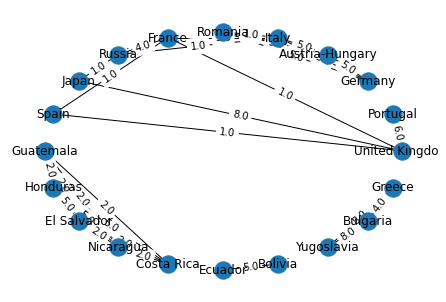

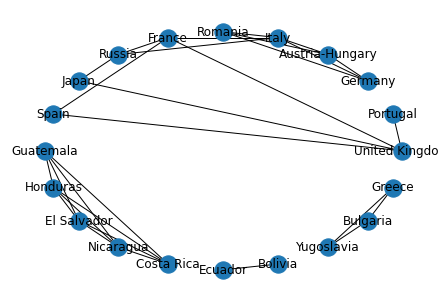

In [38]:
allyG_1913,edgeStrength=getAllianceGraph(alliance_data_1913)
#print(edgeStrength)
visualizeGraph(allyG_1913,edgeStrength)
visualizeGraph(allyG_1913,'')

In [65]:
find_country_rank(allyG_1913,'pagerank')
# edge weights impact pagerank a lot

['United Kingdom',
 'Honduras',
 'Italy',
 'Germany',
 'Austria-Hungary',
 'Yugoslavia',
 'Ecuador',
 'Bolivia',
 'France',
 'Japan',
 'El Salvador',
 'Nicaragua',
 'Costa Rica',
 'Bulgaria',
 'Greece',
 'Romania',
 'Guatemala',
 'Portugal',
 'Russia',
 'Spain']

In [66]:
find_communities(allyG_1913)

(['France', 'Japan', 'Portugal', 'Russia', 'Spain', 'United Kingdom'],
 ['Austria-Hungary', 'Germany', 'Italy', 'Romania'],
 ['Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua'],
 ['Bolivia', 'Ecuador'],
 ['Bulgaria', 'Greece', 'Yugoslavia'])

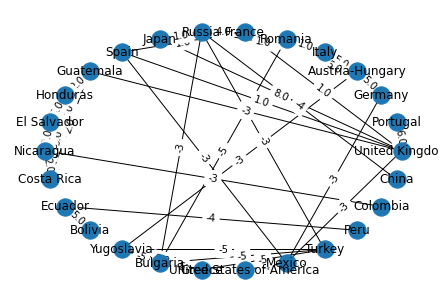

In [39]:
signed_1913,signedES_1913=getSignedGraph(1913)
visualizeGraph(signed_1913,signedES_1913)

In [43]:
print(signedES_1913)
#signed_1913.nodes()

{('United Kingdom', 'Portugal'): 0.6000000000000001, ('Germany', 'Austria-Hungary'): 0.5, ('Germany', 'Italy'): 0.5, ('Austria-Hungary', 'Italy'): 0.5, ('Germany', 'Romania'): 0.5, ('Austria-Hungary', 'Romania'): 0.5, ('Italy', 'Romania'): 0.1, ('France', 'Russia'): 0.4, ('United Kingdom', 'Japan'): 0.7999999999999999, ('France', 'Italy'): 0.3, ('United Kingdom', 'France'): 0.1, ('United Kingdom', 'Spain'): 0.1, ('France', 'Spain'): 0.1, ('Guatemala', 'Honduras'): 0.2, ('Guatemala', 'El Salvador'): 0.2, ('Guatemala', 'Nicaragua'): 0.2, ('Guatemala', 'Costa Rica'): 0.2, ('Honduras', 'El Salvador'): 0.5, ('Honduras', 'Nicaragua'): 0.5, ('Honduras', 'Costa Rica'): 0.5, ('El Salvador', 'Nicaragua'): 0.2, ('El Salvador', 'Costa Rica'): 0.2, ('Nicaragua', 'Costa Rica'): 0.2, ('Italy', 'Russia'): 0.1, ('Russia', 'Japan'): 0.1, ('Ecuador', 'Bolivia'): 0.5, ('Yugoslavia', 'Bulgaria'): -5, ('Greece', 'Bulgaria'): -5, ('Yugoslavia', 'Greece'): 0.7999999999999999, ('Austria-Hungary', 'Yugoslavia')

In [15]:
find_communities(signed_1913)

(['Colombia',
  'Costa Rica',
  'El Salvador',
  'Guatemala',
  'Honduras',
  'Japan',
  'Nicaragua',
  'Portugal',
  'Spain',
  'United Kingdom'],
 ['Austria-Hungary',
  'Bulgaria',
  'China',
  'France',
  'Germany',
  'Greece',
  'Italy',
  'Mexico',
  'Romania',
  'Russia',
  'Turkey',
  'United States of America',
  'Yugoslavia'],
 ['Bolivia', 'Ecuador', 'Peru'])

In [53]:
kernighan_lin_bisection(allyG_1913,weight='weight') 

({'Austria-Hungary',
  'Costa Rica',
  'El Salvador',
  'Germany',
  'Guatemala',
  'Honduras',
  'Italy',
  'Nicaragua',
  'Romania',
  'Spain'},
 {'Bolivia',
  'Bulgaria',
  'Ecuador',
  'France',
  'Greece',
  'Japan',
  'Portugal',
  'Russia',
  'United Kingdom',
  'Yugoslavia'})

In [70]:
yr=1914
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['France', 'Japan', 'Portugal', 'Russia', 'Spain', 'United Kingdom'],
 ['Austria-Hungary', 'Bulgaria', 'Germany', 'Italy', 'Romania', 'Turkey'],
 ['Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua'],
 ['Bolivia', 'Ecuador'],
 ['Greece', 'Yugoslavia'])

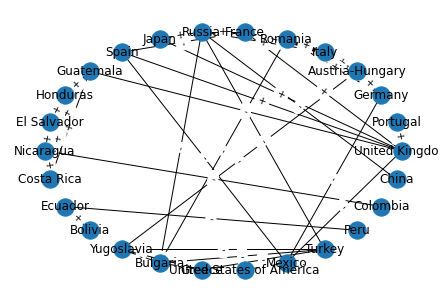

In [16]:
visualizeSigns(signed_1913,signedES_1913)

In [50]:
getUnbalancedTris(signed_1913)

[['Russia', 'Bulgaria', 'Turkey'], ['Yugoslavia', 'Bulgaria', 'Turkey'], ['Bulgaria', 'Greece', 'Turkey']]


0.13636363636363635

In [54]:
time=[]
num_unstable_triangles=[]
for y in range(1901,2013):  #(1901 to 2012)
  print(y)
  time.append(y)
  G,es=getSignedGraph(y)
  tris=getUnbalancedTris(G)
  #print(tris)
  num_unstable_triangles.append(tris)

1901
[]
1902
[]
1903
[]
1904
[['Germany', 'Austria-Hungary', 'Italy'], ['Austria-Hungary', 'Italy', 'Romania']]
1905
[]
1906
[]
1907
[['Guatemala', 'Honduras', 'El Salvador'], ['Guatemala', 'Honduras', 'Costa Rica'], ['Guatemala', 'El Salvador', 'Nicaragua'], ['Honduras', 'Nicaragua', 'Costa Rica'], ['El Salvador', 'Nicaragua', 'Costa Rica']]
1908
[]
1909
[['Guatemala', 'Honduras', 'Nicaragua'], ['Guatemala', 'El Salvador', 'Nicaragua'], ['Honduras', 'Nicaragua', 'Costa Rica'], ['El Salvador', 'Nicaragua', 'Costa Rica']]
1910
[]
1911
[['Germany', 'Austria-Hungary', 'Italy'], ['Austria-Hungary', 'Italy', 'Romania'], ['Italy', 'France', 'Russia']]
1912
[['Austria-Hungary', 'Italy', 'Russia'], ['Italy', 'France', 'Russia']]
1913
[['Russia', 'Bulgaria', 'Turkey'], ['Yugoslavia', 'Bulgaria', 'Turkey'], ['Bulgaria', 'Greece', 'Turkey']]
1914
[['United Kingdom', 'Germany', 'Netherlands'], ['Germany', 'Russia', 'Netherlands']]
1915
[['United Kingdom', 'Germany', 'Sweden'], ['United Kingdom', '

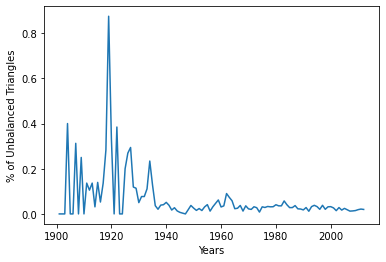

In [55]:
plt.plot(time,num_unstable_triangles)
plt.xlabel('Years')
plt.ylabel('% of Unbalanced Triangles')
plt.show()

In [48]:
for i in range(len(time)):
  print(time[i],num_unstable_triangles[i])

1901 0.0
1902 0.0
1903 0.0
1904 0.4
1905 0.0
1906 0.0
1907 0.3125
1908 0.0
1909 0.25
1910 0.0
1911 0.13636363636363635
1912 0.10526315789473684
1913 0.13636363636363635
1914 0.03125
1915 0.13953488372093023
1916 0.05263157894736842
1917 0.136
1918 0.2830188679245283
1919 0.875
1920 0.3333333333333333
1921 0.0
1922 0.38461538461538464
1923 0.0
1924 0.0
1925 0.2
1926 0.2692307692307692
1927 0.29411764705882354
1928 0.11904761904761904
1929 0.11363636363636363
1930 0.05
1931 0.07692307692307693
1932 0.07692307692307693
1933 0.1111111111111111
1934 0.23404255319148937
1935 0.1282051282051282
1936 0.03646973012399708
1937 0.020703933747412008
1938 0.0389344262295082
1939 0.040829986613119144
1940 0.05114029025570145
1941 0.03839232153569286
1942 0.017142857142857144
1943 0.0273972602739726
1944 0.013138686131386862
1945 0.0068634179821551134
1946 0.003355704697986577
1947 0.0
1948 0.018452803406671398
1949 0.03740036787247088
1950 0.02565668906536347
1951 0.015616585891222402
1952 0.0238095

In [51]:
timeN=[]
num_unstable_trianglesN=[]
for y in range(1901,2013):  #(1901 to 2012)
  print(y)
  timeN.append(y)
  G,es=getSignedGraph(y)
  tris=getUnbalancedTris(G,'num')
  #print(tris)
  num_unstable_trianglesN.append(tris)

1901
[]
1902
[]
1903
[]
1904
[['Germany', 'Austria-Hungary', 'Italy'], ['Austria-Hungary', 'Italy', 'Romania']]
1905
[]
1906
[]
1907
[['Guatemala', 'Honduras', 'El Salvador'], ['Guatemala', 'Honduras', 'Costa Rica'], ['Guatemala', 'El Salvador', 'Nicaragua'], ['Honduras', 'Nicaragua', 'Costa Rica'], ['El Salvador', 'Nicaragua', 'Costa Rica']]
1908
[]
1909
[['Guatemala', 'Honduras', 'Nicaragua'], ['Guatemala', 'El Salvador', 'Nicaragua'], ['Honduras', 'Nicaragua', 'Costa Rica'], ['El Salvador', 'Nicaragua', 'Costa Rica']]
1910
[]
1911
[['Germany', 'Austria-Hungary', 'Italy'], ['Austria-Hungary', 'Italy', 'Romania'], ['Italy', 'France', 'Russia']]
1912
[['Austria-Hungary', 'Italy', 'Russia'], ['Italy', 'France', 'Russia']]
1913
[['Russia', 'Bulgaria', 'Turkey'], ['Yugoslavia', 'Bulgaria', 'Turkey'], ['Bulgaria', 'Greece', 'Turkey']]
1914
[['United Kingdom', 'Germany', 'Netherlands'], ['Germany', 'Russia', 'Netherlands']]
1915
[['United Kingdom', 'Germany', 'Sweden'], ['United Kingdom', '

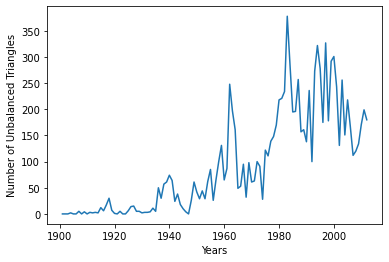

In [57]:
plt.plot(timeN,num_unstable_trianglesN)
plt.xlabel('Years')
plt.ylabel('Number of Unbalanced Triangles')
plt.show()

In [58]:
for i in range(len(time)):
  print(timeN[i],num_unstable_trianglesN[i])

1901 0
1902 0
1903 0
1904 2
1905 0
1906 0
1907 5
1908 0
1909 4
1910 0
1911 3
1912 2
1913 3
1914 2
1915 12
1916 6
1917 17
1918 30
1919 7
1920 1
1921 0
1922 5
1923 0
1924 0
1925 6
1926 14
1927 15
1928 5
1929 5
1930 2
1931 3
1932 3
1933 4
1934 11
1935 5
1936 50
1937 30
1938 57
1939 61
1940 74
1941 64
1942 24
1943 38
1944 18
1945 10
1946 4
1947 0
1948 26
1949 61
1950 42
1951 29
1952 44
1953 29
1954 62
1955 85
1956 26
1957 65
1958 100
1959 131
1960 65
1961 87
1962 248
1963 197
1964 161
1965 49
1966 53
1967 95
1968 32
1969 98
1970 61
1971 63
1972 100
1973 91
1974 28
1975 122
1976 111
1977 139
1978 148
1979 170
1980 218
1981 221
1982 234
1983 378
1984 285
1985 195
1986 196
1987 257
1988 157
1989 161
1990 138
1991 236
1992 100
1993 273
1994 322
1995 278
1996 175
1997 327
1998 178
1999 292
2000 301
2001 243
2002 131
2003 256
2004 151
2005 218
2006 167
2007 112
2008 120
2009 134
2010 171
2011 199
2012 180


In [18]:
yr=1914
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['France', 'Japan', 'Portugal', 'Russia', 'Spain', 'United Kingdom'],
 ['Austria-Hungary', 'Bulgaria', 'Germany', 'Italy', 'Romania', 'Turkey'],
 ['Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua'],
 ['Bolivia', 'Ecuador'],
 ['Greece', 'Yugoslavia'])

In [ ]:
#G2 (WW2)

In [8]:
yr=1938
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['Afghanistan',
  'Bulgaria',
  'China',
  'Czechoslovakia',
  'Egypt',
  'Estonia',
  'Finland',
  'France',
  'Greece',
  'Iran',
  'Iraq',
  'Latvia',
  'Lithuania',
  'Mongolia',
  'Poland',
  'Portugal',
  'Romania',
  'Russia',
  'Saudi Arabia',
  'Turkey',
  'United Kingdom',
  'Yemen Arab Republic',
  'Yugoslavia'],
 ['Argentina',
  'Bolivia',
  'Brazil',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Cuba',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Albania', 'Austria', 'Germany', 'Hungary', 'Italy', 'Japan'])

In [69]:
yr=1939
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)
#kernighan_lin_bisection(grp,weight='weight') 

(['Afghanistan',
  'Bulgaria',
  'China',
  'Czechoslovakia',
  'Egypt',
  'Finland',
  'France',
  'Greece',
  'Iran',
  'Iraq',
  'Mongolia',
  'Poland',
  'Romania',
  'Russia',
  'Saudi Arabia',
  'Turkey',
  'United Kingdom',
  'Yemen Arab Republic',
  'Yugoslavia'],
 ['Albania',
  'Denmark',
  'Estonia',
  'Germany',
  'Hungary',
  'Italy',
  'Japan',
  'Latvia',
  'Lithuania',
  'Portugal',
  'Spain'],
 ['Argentina',
  'Bolivia',
  'Brazil',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Cuba',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'United States of America',
  'Uruguay',
  'Venezuela'])

In [10]:
yr=1940
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['Egypt', 'Portugal', 'Spain', 'Thailand', 'United Kingdom'],
 ['Argentina',
  'Bolivia',
  'Brazil',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Cuba',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Afghanistan',
  'Bulgaria',
  'China',
  'Czechoslovakia',
  'Denmark',
  'Estonia',
  'Finland',
  'France',
  'Germany',
  'Greece',
  'Hungary',
  'Iran',
  'Iraq',
  'Italy',
  'Japan',
  'Latvia',
  'Lithuania',
  'Mongolia',
  'Romania',
  'Russia',
  'Saudi Arabia',
  'Turkey',
  'Yemen Arab Republic',
  'Yugoslavia'])

In [ ]:
#G3 (Cold War Era)

In [16]:
yr=1987
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['Portugal', 'United Kingdom'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Bolivia',
  'Brazil',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Bulgaria', 'Hungary', 'Mongolia', 'Romania', 'Russia'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen Arab Republic',
  "Yemen People's Republic"],
 ['Czechoslovakia', 'Poland'])

In [11]:
yr=1988
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['Portugal', 'United Kingdom'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Bolivia',
  'Brazil',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Bulgaria', 'Hungary', 'Mongolia', 'Romania', 'Russia'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen Arab Republic',
  "Yemen People's Republic"],
 ['Czechoslovakia', 'Poland'])

In [12]:
yr=1989
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['Portugal', 'United Kingdom'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Bolivia',
  'Brazil',
  'Canada',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Bulgaria', 'Hungary', 'Mongolia', 'Romania', 'Russia'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen Arab Republic',
  "Yemen People's Republic"],
 ['Czechoslovakia', 'Poland'])

In [13]:
yr=1990
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['Portugal', 'United Kingdom'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Bolivia',
  'Brazil',
  'Canada',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Mongolia', 'Russia'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen',
  'Yemen Arab Republic',
  "Yemen People's Republic"],
 ['Egypt'])

In [14]:
yr=1991
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['United Kingdom'],
 ['Portugal'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Belize',
  'Bolivia',
  'Brazil',
  'Canada',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Guyana',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Mongolia', 'Russia'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen'])

In [15]:
yr=1992
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['United Kingdom'],
 ['Portugal'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Belize',
  'Bolivia',
  'Brazil',
  'Canada',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Guyana',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen'])

In [17]:
yr=1999
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['United Kingdom'],
 ['Portugal'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Belize',
  'Bolivia',
  'Brazil',
  'Canada',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Guyana',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen'])

In [18]:
yr=2000
data=getAllianceDataByYear(yr)
grp,es=getAllianceGraph(data)
find_communities(grp)

(['United Kingdom'],
 ['Portugal'],
 ['Antigua & Barbuda',
  'Argentina',
  'Bahamas',
  'Barbados',
  'Belize',
  'Bolivia',
  'Brazil',
  'Canada',
  'Chile',
  'Colombia',
  'Costa Rica',
  'Dominica',
  'Dominican Republic',
  'Ecuador',
  'El Salvador',
  'Grenada',
  'Guatemala',
  'Guyana',
  'Haiti',
  'Honduras',
  'Jamaica',
  'Mexico',
  'Nicaragua',
  'Panama',
  'Paraguay',
  'Peru',
  'St. Kitts and Nevis',
  'St. Lucia',
  'St. Vincent and the Grenadines',
  'Suriname',
  'Trinidad and Tobago',
  'United States of America',
  'Uruguay',
  'Venezuela'],
 ['Algeria',
  'Bahrain',
  'Djibouti',
  'Egypt',
  'Iraq',
  'Jordan',
  'Kuwait',
  'Lebanon',
  'Libya',
  'Mauritania',
  'Morocco',
  'Oman',
  'Qatar',
  'Saudi Arabia',
  'Somalia',
  'Sudan',
  'Syria',
  'Tunisia',
  'United Arab Emirates',
  'Yemen'])